In [205]:
import pandas as pd
import numpy as np
import torch
df_spectra = pd.read_csv('../../data/spectra.csv').T
print(df_spectra.shape)
df_spectra.reset_index(inplace=False)
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
print(data_sp.shape)
data_scaled = data_sp / np.max(data_sp)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
# wavelengths = data[:, 0]  # Shape: [17]
fluxes_sp = data_sp[:, 0:]  # Transpose to get shape [10000, 17]
print(fluxes_sp.shape)
# Prepare inputs for the model
df_photo = pd.read_csv('../../data/interpolated_spectra.csv').T
print(df_photo.shape)
df_photo.reset_index(inplace=False)
df_photo.columns = range(len(df_spectra.columns))
data_ph = df_photo.values.astype(np.float64)
print(data_ph.shape)
data_scaled_ph = data_ph / np.max(data_ph)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
# wavelengths = data[:, 0]  # Shape: [17]
fluxes_ph = data_ph[:, 0:]  # Transpose to get shape [10000, 17]
print(fluxes_ph.shape)

(206, 10000)
(206, 10000)
(206, 10000)
(17, 10000)
(17, 10000)
(17, 10000)


In [206]:
import torch
import torch.nn as nn
import torch.optim as optim



In [207]:
class Generator(nn.Module):
    def __init__(self, input_dim=17, output_dim=206, hidden_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)


In [208]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=206, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


In [209]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class SpectraDataset(Dataset):
    def __init__(self, photometry_file, spectra_file):
        # Load data
        self.photometry = photometry_file  # Shape (10000, 17)
        self.spectra = spectra_file        # Shape (10000, 206)
        print(self.spectra.shape)
        # Convert to torch tensors
        self.photometry = torch.tensor(self.photometry, dtype=torch.float32)
        self.spectra = torch.tensor(self.spectra, dtype=torch.float32)
    
    def __len__(self):
        return len(self.photometry)
    
    def __getitem__(self, idx):
        return self.spectra[idx], self.photometry[idx]

# Initialize dataset and dataloader
dataset = SpectraDataset(data_ph.T, data_sp.T)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)


(10000, 206)


In [210]:
# Hyperparameters
latent_dim = 17  # Photometry input (number of bands)
spectra_dim = 206  # Full spectrum output
hidden_dim = 128

# Initialize models
generator = Generator(input_dim=latent_dim, output_dim=spectra_dim, hidden_dim=hidden_dim)
discriminator = Discriminator(input_dim=spectra_dim, hidden_dim=hidden_dim)

# Optimizers
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()


In [211]:
# Training Loop
num_epochs = 20000
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in range(num_epochs):
    for i, (real_spectra, photometry_data) in enumerate(dataloader):
        real_spectra = real_spectra.to(device)
        photometry_data = photometry_data.to(device)
        
        # ======== Train Discriminator ========
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator on real data
        outputs = discriminator(real_spectra)
        d_loss_real = criterion(outputs, real_labels)

        # Discriminator on fake data
        fake_spectra = generator(photometry_data)
        outputs = discriminator(fake_spectra.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ======== Train Generator ========
        fake_spectra = generator(photometry_data)
        outputs = discriminator(fake_spectra)
        g_loss = criterion(outputs, real_labels)  # Trick discriminator into thinking generated spectra are real

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


Epoch [0/20000], d_loss: 0.27416130900382996, g_loss: 2.0363612174987793
Epoch [100/20000], d_loss: 5.552936272579245e-06, g_loss: 14.106668472290039
Epoch [200/20000], d_loss: 0.0009174725273624063, g_loss: 9.406436920166016
Epoch [300/20000], d_loss: 1.2755978673339996e-07, g_loss: 18.378894805908203
Epoch [400/20000], d_loss: 2.7801308988273377e-07, g_loss: 18.647865295410156
Epoch [500/20000], d_loss: 1.4543891666107811e-05, g_loss: 17.405784606933594
Epoch [600/20000], d_loss: 8.999459168990143e-06, g_loss: 13.579258918762207
Epoch [700/20000], d_loss: 0.0004246671451255679, g_loss: 12.490619659423828
Epoch [800/20000], d_loss: 1.845058648086706e-07, g_loss: 18.110157012939453
Epoch [900/20000], d_loss: 1.039115431922255e-06, g_loss: 20.061492919921875
Epoch [1000/20000], d_loss: 7.467247087333817e-08, g_loss: 24.607376098632812
Epoch [1100/20000], d_loss: 3.551259055711853e-07, g_loss: 17.16732406616211
Epoch [1200/20000], d_loss: 3.05501146158349e-07, g_loss: 17.066083908081055


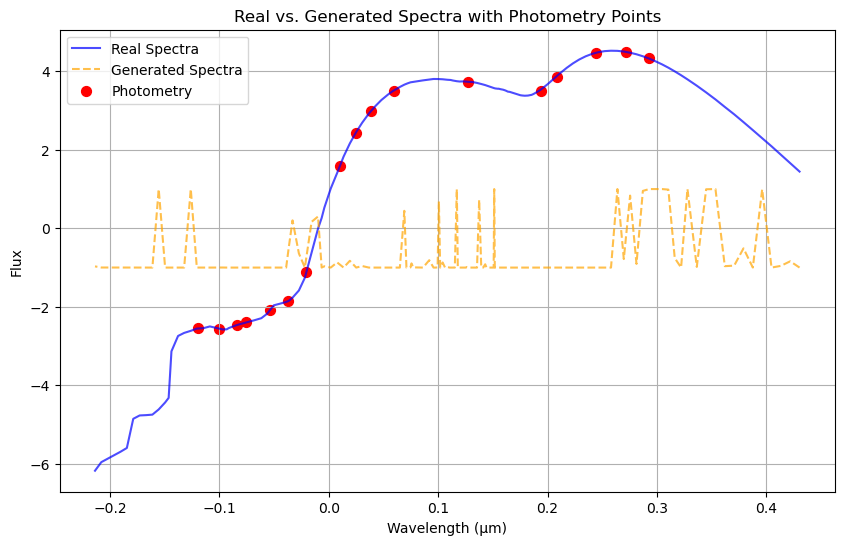

In [212]:
import matplotlib.pyplot as plt

def plot_spectra(real_spectra, photometry, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0):
    """
    Plots real spectra, photometry points, and generated spectra.
    
    Parameters:
        real_spectra (torch.Tensor): Real spectra data, shape [batch_size, 206]
        photometry (torch.Tensor): Photometry data, shape [batch_size, 17]
        generated_spectra (torch.Tensor): Generated spectra data, shape [batch_size, 206]
        photometry_wavelengths (list or array): Wavelengths corresponding to the photometry data (17 values)
        spectra_wavelengths (list or array): Wavelengths corresponding to the spectra data (206 values)
        index (int): Index of the sample in the batch to plot
    """
    # Convert tensors to numpy for plotting
    real_spectra = real_spectra.detach().cpu().numpy()[index]
    generated_spectra = generated_spectra.detach().cpu().numpy()[index]
    photometry = photometry.detach().cpu().numpy()[index]
    
    # Plotting the real spectra
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, real_spectra, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, generated_spectra, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, photometry, label='Photometry', color='red', s=50)
    
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after training
real_spectra, photometry_data = next(iter(dataloader))  # Get a batch of real spectra and photometry
real_spectra = real_spectra.to(device)
photometry_data = photometry_data.to(device)

# Generate spectra from the photometry data
generator.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    generated_spectra = generator(photometry_data)


df = pd.read_csv('../../data/interpolated_spectra.csv').T

df.reset_index(inplace=True)
df.columns = range(len(df.columns))
data = df.values.astype(np.float64)
# data = data / data.values.max()

data_scaled = data / np.max(data)
dfspectr = pd.read_csv('../../data/spectra.csv').T

dfspectr.reset_index(inplace=True)
dfspectr.columns = range(len(dfspectr.columns))
dataspectr = dfspectr.values.astype(np.float64)
# data = data / data.values.max()

dataspectr = dataspectr / np.max(dataspectr)
# Separate wavelengths and fluxes
# wavelengths_spectra = dataspectr[:, 0]  # Shape: [17,]

# Define wavelengths for plotting (replace with actual wavelengths)
photometry_wavelengths = data_scaled[:, 0] # Example for 17 bands
spectra_wavelengths =  dataspectr[:, 0]  # Example for 206 points

# Plot the first sample in the batch
plot_spectra(real_spectra, photometry_data, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0)
